In [10]:
import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# Set manual seed for reproducibility
torch.manual_seed(1)
np.random.seed(1)

# Generate synthetic data for XOR problem
# Generate 200 samples of 2D data points uniformly distributed between -1 and 1 for both features.
x = np.random.uniform(low=-1, high=1, size=(200, 2))
# Label these points with 0 or 1 based on the XOR rule: a point is labeled 1 if either both x and y are positive or both are negative; otherwise, it is labeled 0.
y = np.ones(len(x))
y[np.logical_and(x[:, 0] < 0, x[:, 1] < 0)] = 0
y[np.logical_and(x[:, 0] > 0, x[:, 1] > 0)] = 0

print(x.shape)
print(y.shape)
print(x[:2])

(200, 2)
(200,)
[[-0.16595599  0.44064899]
 [-0.99977125 -0.39533485]]


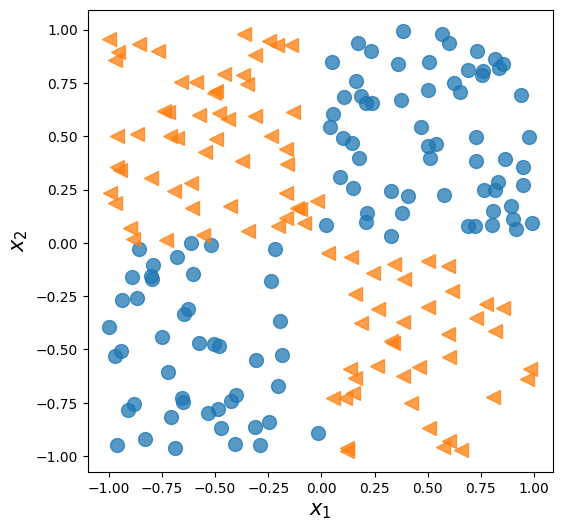

In [4]:
# Plot the data
fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0], x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0], x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)
plt.show()

In [12]:
# Split the data into training and validation sets
# Turn numpy into tensors
n_train = 100
x_train_ts = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train_ts = torch.tensor(y[:n_train], dtype=torch.float32)
x_valid_ts = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_valid_ts = torch.tensor(y[n_train:], dtype=torch.float32)

print(x_train_ts.shape)
print(y_train_ts.shape)
print(x_train_ts[:2])
print(y_train_ts[:2])

torch.Size([100, 2])
torch.Size([100])
tensor([[-0.1660,  0.4406],
        [-0.9998, -0.3953]])
tensor([1., 0.])


In [7]:
# Define the model
model = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid()
)

In [8]:
# Initialize the binary cross-entropy loss
loss_fn = nn.BCELoss()

# Initialize the SGD optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [11]:
# Define the train dataset
train_ds = TensorDataset(x_train_ts, y_train_ts)

In [25]:
def fit_model(model: torch.nn.Module,
                train_ds: TensorDataset,
                loss_fn: nn.Module,
                optimizer: optim.Optimizer,
                x_valid: torch.Tensor = None,
                y_valid: torch.Tensor = None,
                accuracy_fn = None,
                num_epochs = 100,
                batch_size = 32,
                seed = 42,
                transform_pred = None,
                device: torch.device = "cpu"):
    # variables
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs    
    torch.manual_seed(seed)
    train_dl = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
    n_train = len(train_dl.dataset)
    # set model to device
    model.to(device)
    for epoch in range(num_epochs):
        # set model to training mode
        model.train()
        # mini-batch training
        for x_batch, y_batch in train_dl:
            # Send data to device
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # Forward pass
            y_pred = model(x_batch)
            if transform_pred:
                y_pred = transform_pred(y_pred)

            # Compute loss
            loss = loss_fn(y_pred, y_batch)

            # Do backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            accuracy_batch = 0
            if accuracy_fn:
                accuracy_batch = accuracy_fn(y_pred, y_batch)
            loss_hist_train[epoch] += loss.item()
            accuracy_hist_train[epoch] += accuracy_batch

        # Compute store loss and accuracy as percent
        loss_hist_train[epoch] /= n_train
        accuracy_hist_train[epoch] /= n_train
        
        if x_valid is not None and y_valid is not None:
            model.eval()
            with torch.no_grad():
                y_pred = model(x_valid)
                if transform_pred:
                    y_pred = transform_pred(y_pred)                
                loss = loss_fn(y_pred, y_valid)

                accuracy_batch = 0
                if accuracy_fn:
                    accuracy_batch = accuracy_fn(y_pred, y_valid)
                loss_hist_valid[epoch] += loss.item()
                accuracy_hist_valid[epoch] += accuracy_batch
            
            # Compute store validation loss and accuracy as percent
            loss_hist_valid[epoch] /= len(y_valid)
            accuracy_hist_valid[epoch] /= len(y_valid)

        # Print out
        if epoch % 10 == 0:
            if x_valid is not None and y_valid is not None:
                print(f"Train loss: {loss_hist_train[epoch]:.5f} | Train accuracy: {accuracy_hist_train[epoch]:.2f}% | Val loss: {loss_hist_valid[epoch]:.5f} | Val accuracy: {accuracy_hist_valid[epoch]:.2f}%")
            else:
                print(f"Train loss: {loss_hist_train[epoch]:.5f} | Train accuracy: {accuracy_hist_train[epoch]:.2f}%")

    # Return result    
    return (loss_hist_train, accuracy_hist_train, loss_hist_valid, accuracy_hist_valid)

In [15]:
def accuracy_binaryclass_fn(y_pred, y, threshold = 0.5):
    is_correct = ((y_pred >= threshold).float() == y).float()
    return is_correct.mean()

def transform_pred_binary(y_pred):
    return y_pred.squeeze()

In [30]:
loss_hist_train, accuracy_hist_train, loss_hist_valid, accuracy_hist_valid = fit_model(model, 
    train_ds, 
    loss_fn, 
    optimizer,
    x_valid_ts,
    y_valid_ts,
    batch_size=2,
    seed=1,
    num_epochs = 200,
    accuracy_fn=accuracy_binaryclass_fn,
    transform_pred=transform_pred_binary)

Train loss: 0.34268 | Train accuracy: 0.33% | Val loss: 0.00680 | Val accuracy: 0.01%
Train loss: 0.34267 | Train accuracy: 0.33% | Val loss: 0.00680 | Val accuracy: 0.01%
Train loss: 0.34264 | Train accuracy: 0.33% | Val loss: 0.00680 | Val accuracy: 0.01%
Train loss: 0.34263 | Train accuracy: 0.34% | Val loss: 0.00680 | Val accuracy: 0.01%
Train loss: 0.34261 | Train accuracy: 0.34% | Val loss: 0.00680 | Val accuracy: 0.01%
Train loss: 0.34260 | Train accuracy: 0.34% | Val loss: 0.00680 | Val accuracy: 0.01%
Train loss: 0.34258 | Train accuracy: 0.34% | Val loss: 0.00680 | Val accuracy: 0.01%
Train loss: 0.34258 | Train accuracy: 0.34% | Val loss: 0.00680 | Val accuracy: 0.01%
Train loss: 0.34256 | Train accuracy: 0.34% | Val loss: 0.00680 | Val accuracy: 0.01%
Train loss: 0.34255 | Train accuracy: 0.34% | Val loss: 0.00680 | Val accuracy: 0.01%
Train loss: 0.34254 | Train accuracy: 0.34% | Val loss: 0.00680 | Val accuracy: 0.01%
Train loss: 0.34253 | Train accuracy: 0.34% | Val loss

In [23]:
def plot_learning_curve(loss_hist_train, accuracy_hist_train, loss_hist_valid = None, accuracy_hist_valid = None, loss_title='Loss', accuracy_title='Accuracy'):
    # Visualization setup
    loss_legend = ['Train Loss']
    acc_legend = ['Train Acc']
    fig = plt.figure(figsize=(16, 4))

    # Plot for training loss
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(loss_hist_train, lw=4)
    if loss_hist_valid:
        ax.plot(loss_hist_valid, lw=4)
        loss_legend.append('Valid Loss')
    ax.legend(loss_legend)
    ax.set_title(loss_title, size=15)
    ax.set_xlabel('Epoch', size=15)
    ax.tick_params(axis='both', which='major', labelsize=15)

    # Plot for training accuracy
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(accuracy_hist_train, lw=4)
    if accuracy_hist_valid:
        ax.plot(accuracy_hist_valid, lw=4)
        acc_legend.append('Valid Acc')
    ax.legend(acc_legend)
    ax.set_title(accuracy_title, size=15)
    ax.set_xlabel('Epoch', size=15)
    ax.tick_params(axis='both', which='major', labelsize=15)

    plt.show()

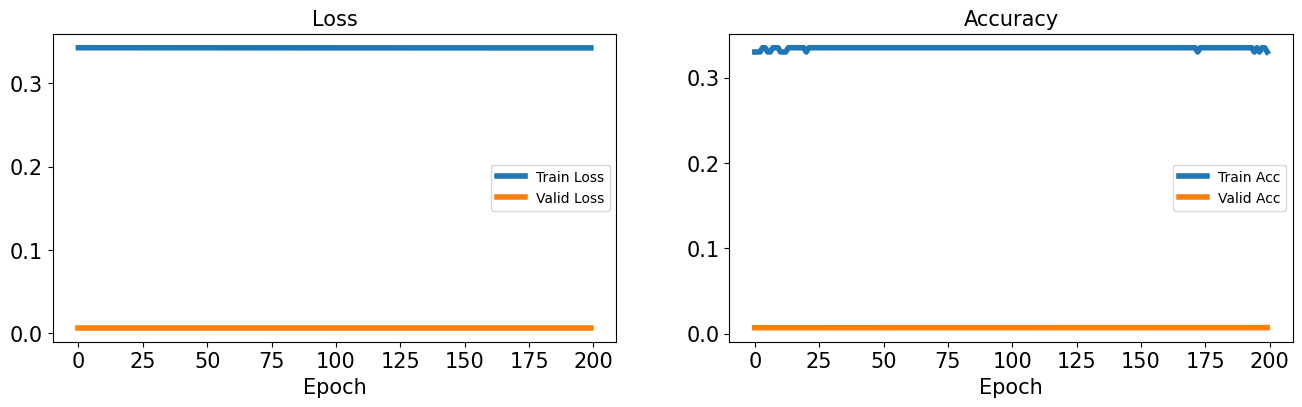

In [31]:
plot_learning_curve(loss_hist_train, accuracy_hist_train, loss_hist_valid, accuracy_hist_valid)